# Introduction
This notebook is part of a machine learning for healthcare exercise, focusing on using the Responsible AI (RAI) package to enhance clinical decision-making. The toolkit will be used to analyze opioid use disorder (OD) risk, with three key objectives:

1. Analyze Errors and Explore Interpretability of Models: We will run Interpret-Community’s global explainers to generate feature importance insights and visualize model errors with the Error Analysis dashboard

2. Plan real-world action through counterfactual and causal analysis: By leveraging counterfactual examples and causal inference, we will explore decision-making strategies based on opioid prescription patterns and patient comorbidities to understand possible interventions and their impacts

3. Assess addiction risk predictions: A classification model trained on patient-level features (income, surgeries, opioid prescription days, and comorbidities A–V) will be evaluated to examine its performance in predicting risk of opioid use disorder and to inform prevention strategies

**The goal is to provide non-trivial insights for clinical decision making, leveraging machine learning paired with responsible AI tools, to improve patient outcomes in the healthcare context.**

Based on notebooks from the [Responsible AI toolkit](https://github.com/microsoft/responsible-ai-toolbox/tree/main/notebooks)


# Data Set Characteristics

Number of Instances: patient-level records (rows)

Number of Attributes: 20 predictive attributes and 1 target class

Attribute Information:
- OD (target): whether the patient had an opioid use disorder diagnosis (binary: 1 = yes, 0 = no)
- Low_inc: low income flag (1 = low income, 0 = not low income)
- Surgery: whether the patient underwent major surgery in the 2 years
- rx_ds: number of days of prescribed opioids in the 2 years
- A: infectious diseases group A (binary flag)
- B: infectious diseases group B
- C: malignant neoplasm
- D: benign neoplasm
- E: endocrine conditions
- F: mental and behavioral health conditions (excluding opioid-related)
- H: ear conditions
- I: circulatory system conditions
- J: respiratory system conditions
- K: digestive system conditions
- L: skin conditions
- M: musculoskeletal system conditions
- N: urinary system conditions
- R: other signs and symptoms
- S: injuries
- T: burns and toxic conditions
- V: external trauma conditions

class:
- OD = 1: patient identified with opioid use disorder in the 2 years
- OD = 0: patient without opioid use disorder


# 1. Setup
- responsibleai and raiwidgets provide RAIInsights and the dashboard
- fairlearn provides fairness metrics and mitigation algorithms used under the hood
- imbalanced-learn offers resampling utilities if you want to experiment with imbalance mitigation

In [1]:
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate, false_positive_rate
from scipy.stats import spearmanr, kendalltau
from raiwidgets import ResponsibleAIDashboard
from responsibleai import RAIInsights
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score,        # Area under ROC, measures ranking ability across thresholds
    average_precision_score,  # Area under precision-recall curve, better under imbalance
    # Mean squared error of predicted probabilities, lower = better calibration
    brier_score_loss,
    log_loss,             # Cross-entropy penalty, punishes overconfident wrong predictions
    matthews_corrcoef,    # Balanced correlation metric, robust when classes are imbalanced
    confusion_matrix,     # Counts of TP, FP, TN, FN at a given threshold
    precision_recall_curve,  # Gives precision and recall values at different thresholds
    auc,                  # Generic trapezoidal area under a curve
    precision_score,      # Share of positive predictions that are correct
    recall_score,         # Share of true positives the model actually finds
    RocCurveDisplay,      # Quick ROC curve plotting helper
    PrecisionRecallDisplay  # Quick precision-recall curve plotting helper
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path
import sys
from typing import cast
sys.path.append("/mnt/data")
from utils import (
    positive_scores,
    auc_report,
    tradeoff_table,
    pick_threshold_cost,
    pick_threshold_recall_floor,
    pick_threshold_workload,
    summary_at_threshold,
    plot_recall_floor_curves,
    plot_cumulative_recall_at_threshold,
    plot_topk_at_threshold
)

# Fairness utilities for quick, programmatic checks

RANDOM_STATE = 42

# 2. Data Load

In [2]:
# Path to your CSV (update if needed for your system)
DATA_PATH = "./Data/opiod_raw_data.csv"

df_raw = pd.read_csv(DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head()

Shape: (1000, 22)


,ID,OD,Low_inc,SURG,rx ds,A,B,C,D,E,...,I,J,K,L,M,N,R,S,T,V
0,1,1,1,0,516,0,0,0,1,0,...,1,0,1,1,1,0,1,0,0,0
1,2,1,1,0,119,0,0,1,0,0,...,1,1,0,0,1,1,1,1,0,0
2,3,1,1,1,925,1,1,0,1,1,...,1,0,0,0,1,0,1,0,1,0
3,4,0,1,0,393,1,1,0,0,0,...,0,0,1,1,1,0,1,1,1,0
4,5,1,1,0,630,0,0,0,0,1,...,0,0,0,0,1,1,1,0,0,0


# 3. Basic cleaning and schema alignment

In [3]:
# Create a copy of the raw DataFrame
df = df_raw.copy()

# Standardize column names
df.columns = [c.strip().replace(" ", "_").replace("-", "_")
              for c in df.columns]

# Drop ID column
if df.shape[1] > 0:
    df = df.drop(columns=[df.columns[0]])

# Harmonize known aliases
if "SURG" in df.columns and "Surgery" not in df.columns:
    df = df.rename(columns={"SURG": "Surgery"})

# Expected columns from the data dictionary
expected_cols = [
    "OD", "Low_inc", "Surgery", "rx_ds",
    "A", "B", "C", "D", "E", "F", "H", "I", "J", "K", "L", "M", "N", "R", "S", "T", "V"
]

missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Helper to coerce various binary encodings to 0/1


def to_binary(s: pd.Series) -> pd.Series:
    if s.dtype == "O":
        mapped = s.astype(str).str.strip().str.lower().map({
            "1": 1, "0": 0,
            "y": 1, "n": 0,
            "yes": 1, "no": 0,
            "true": 1, "false": 0
        })
        s = pd.to_numeric(mapped, errors="coerce")
    else:
        s = pd.to_numeric(s, errors="coerce")
    return (s.fillna(0) > 0).astype(int)


# Target is binary 0/1
df["OD"] = to_binary(df["OD"])

# rx_ds is numeric count of opioid prescription days
df["rx_ds"] = pd.to_numeric(df["rx_ds"], errors="coerce")

# Binary predictors: Low_inc, Surgery, and A..V
binary_cols = ["Low_inc", "Surgery", "A", "B", "C", "D", "E",
               "F", "H", "I", "J", "K", "L", "M", "N", "R", "S", "T", "V"]
df[binary_cols] = df[binary_cols].apply(to_binary)

df.head()

,OD,Low_inc,Surgery,rx_ds,A,B,C,D,E,F,...,I,J,K,L,M,N,R,S,T,V
0,1,1,0,516,0,0,0,1,0,1,...,1,0,1,1,1,0,1,0,0,0
1,1,1,0,119,0,0,1,0,0,1,...,1,1,0,0,1,1,1,1,0,0
2,1,1,1,925,1,1,0,1,1,0,...,1,0,0,0,1,0,1,0,1,0
3,0,1,0,393,1,1,0,0,0,1,...,0,0,1,1,1,0,1,1,1,0
4,1,1,0,630,0,0,0,0,1,1,...,0,0,0,0,1,1,1,0,0,0


# 4. Feature matrix and 80/15/5 stratified split

In [4]:
target_col = "OD"
num_cols = ["rx_ds"]
cat_like_binary_cols = binary_cols.copy()

X = df[num_cols + cat_like_binary_cols].copy()
y = df[target_col].copy()

# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Split temp into validation and test, 15% each overall
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE
)

print("Shapes")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:",   X_val.shape,   "y_val:",   y_val.shape)
print("X_test:",  X_test.shape,  "y_test:",  y_test.shape)

# Sanity check class balance


def _dist(s):
    vc = s.value_counts(normalize=True).sort_index()
    return {"p(OD=0)": float(vc.get(0, 0.0)), "p(OD=1)": float(vc.get(1, 0.0))}


print("Class distribution overall:", _dist(y))
print("Class distribution train:",   _dist(y_train))
print("Class distribution val:",     _dist(y_val))
print("Class distribution test:",    _dist(y_test))

Shapes
X_train: (800, 20) y_train: (800,)
X_val: (150, 20) y_val: (150,)
X_test: (50, 20) y_test: (50,)
Class distribution overall: {'p(OD=0)': 0.819, 'p(OD=1)': 0.181}
Class distribution train: {'p(OD=0)': 0.81875, 'p(OD=1)': 0.18125}
Class distribution val: {'p(OD=0)': 0.82, 'p(OD=1)': 0.18}
Class distribution test: {'p(OD=0)': 0.82, 'p(OD=1)': 0.18}


# 5. Modeling pipeline, training, and calibration

## Setting a baseline
A naive majority-class baseline clarifies the minimum standard any model must beat, highlighting the danger of ignoring minority patients and ensuring improvements carry meaningful weight in healthcare decision making

**ROC AUC**  
- 0.5 → no discrimination
- 0.6–0.7 → poor
- 0.7–0.8 → fair
- 0.8–0.9 → good
- ≥ 0.9 → excellent

**PR AUC**  
- Must be interpreted against event prevalence `p` in the validation set  

Dummy baseline
PR AUC: 0.180
ROC AUC: 0.500
Prevalence p = 0.180  |  PR AUC lift = 1.00× over baseline


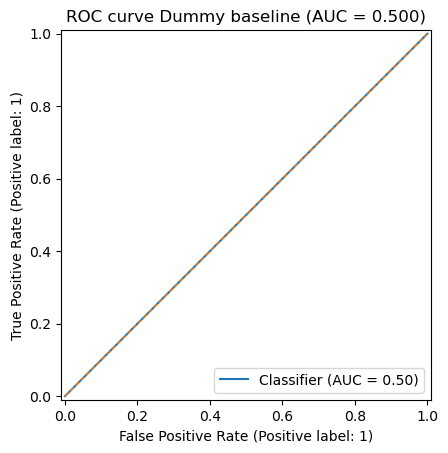

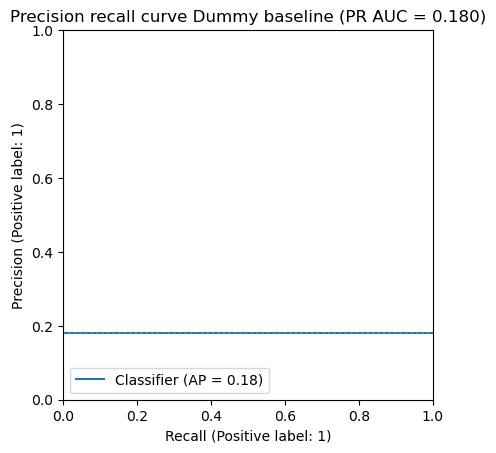

In [5]:
# Baseline: DummyClassifier (majority class)
dummy_clf = DummyClassifier(
    strategy="most_frequent", random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

proba_val = dummy_clf.predict_proba(X_val)
pos_idx = int(np.where(dummy_clf.classes_ == 1)[0][0])  # index for class "1"
y_score_val = np.asarray(proba_val)[:, pos_idx]

# Evaluate on validation
y_score_val = positive_scores(dummy_clf, X_val)
metrics_dummy = auc_report(
    y_val, y_score_val, name="Dummy baseline", plot=True)

## Preprocesing our Pipeline

[Scikit-learn preprocessing](https://scikit-learn.org/stable/api/sklearn.preprocessing.html) standardizes and transforms features for modeling, including scaling, encoding, and imputation. Helping to maintain a consistent data transformation workflow

In [6]:
# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("bin", binary_transformer, cat_like_binary_cols)
    ],
    remainder="drop",  # drops any column not in previously specified
    verbose_feature_names_out=False  # keeps original feature names
)

# Logistic Regression baseline with variance filter
base_clf = Pipeline(steps=[
    ("prep", preprocess),
    # Eliminates features with zero variance
    ("varth", VarianceThreshold(threshold=0.0)),
    ("model", LogisticRegression(
        solver="liblinear",  # See details in course material
        class_weight="balanced",  # Adjusts weights for class imbalance
        random_state=RANDOM_STATE,
        max_iter=200
    ))
])

## Basic preliminary model performance check

base_clf
PR AUC: 0.495
ROC AUC: 0.750
Prevalence p = 0.180  |  PR AUC lift = 2.75× over baseline


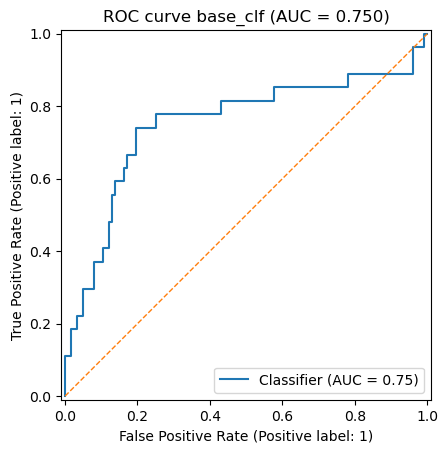

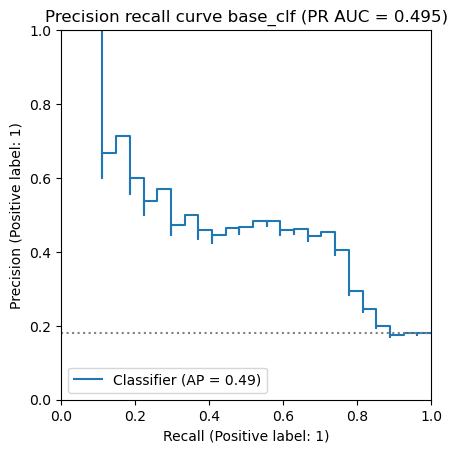

In [7]:
# Fit base model
base_clf.fit(X_train, y_train)

# Evaluate on validation
y_score_val = positive_scores(base_clf, X_val)
metrics_base = auc_report(y_val, y_score_val, name="base_clf", plot=True)

## Recalibrating the probabilities

**1. Reliable probabilities**  
- Turns raw scores into real probabilities  
- Ensures predictions match observed outcome frequencies  
- Prevents overly high or low risk estimates  

**2. Better clinical decisions**  
- Essential when risk values guide medical choices  
- Supports thresholds with clear clinical meaning
- Reduces wasted clinical resources  

**3. Trust and adoption**  
- Builds trust in AI decisions  
- Enables safer patient outcomes

In [8]:
# Calibrate probabilities using CV on training data
calibrated_clf = CalibratedClassifierCV(
    estimator=base_clf,
    method="sigmoid",
    cv=5
)
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['rx_ds']),
                                                                                  ('bin',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='most_frequent'))]),
                                                                                   ['Low_inc',
                                                                                    'Surgery',
                                                                                    'A',
                                                                                    'B',
                                                                                    'C',
                                                                                    'D',
                                                                                    'E',
                                                                                    'F',
                                                                                    'H',
                                                                                    'I',
                                                                                    'J',
                                                                                    'K',
                                                                                    'L',
                                                                                    'M',
                                                                                    'N',
                                                                                    'R',
                                                                                    'S',
                                                                                    'T',
                                                                                    'V'])],
                                                                    verbose_feature_names_out=False)),
                                                 ('varth', VarianceThreshold()),
                                                 ('model',
                                                  LogisticRegression(class_weight='balanced',
                                                                     max_iter=200,
                                                                     random_state=42,
                                                                     solver='liblinear'))]))

,Risk_band,Patients,Avg_pred_before,Actual_OD_rate,Avg_pred_after
0,Q1,5,0.219,0.0,0.082
1,Q2,5,0.256,0.2,0.094
2,Q3,5,0.313,0.0,0.113
3,Q4,5,0.331,0.0,0.119
4,Q5,5,0.391,0.0,0.141
5,Q6,5,0.482,0.2,0.178
6,Q7,5,0.633,0.4,0.260
7,Q8,5,0.691,0.2,0.300
8,Q9,5,0.744,0.2,0.341
9,Q10,5,0.800,0.6,0.399


Check sizes
len(X_train) = 800 len(X_val) = 150 len(X_test) = 50
Rows in table sum to 50
Points near the diagonal mean predicted risk matches observed OD frequency


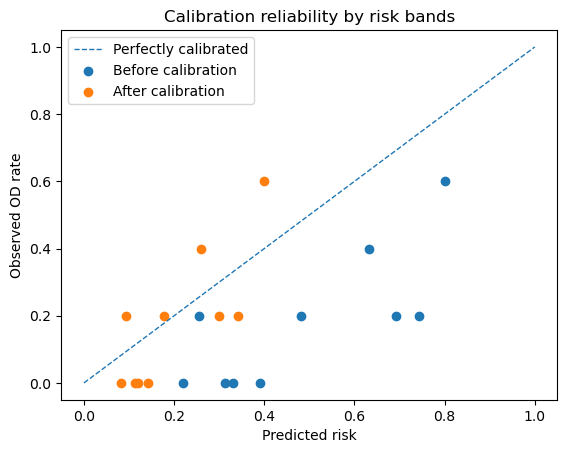

In [9]:
# Quantile bands on test only
base_clf_uncal = clone(base_clf).fit(X_train, y_train)
p_before = base_clf_uncal.predict_proba(X_test)[:, 1]
p_after = calibrated_clf.predict_proba(X_test)[:, 1]

df_cal = pd.DataFrame({"Actual_OD": y_test.values, "Pred_before": p_before,
                      "Pred_after": p_after}, index=X_test.index)

# 10 quantile bands with similar counts
df_cal["Risk_band"] = pd.qcut(df_cal["Pred_after"], q=10, labels=[
                              f"Q{i}" for i in range(1, 11)], duplicates="drop")

summary = (
    df_cal.groupby("Risk_band", observed=True)
    .agg(Patients=("Actual_OD", "size"),
         Avg_pred_before=("Pred_before", "mean"),
         Actual_OD_rate=("Actual_OD", "mean"),
         Avg_pred_after=("Pred_after", "mean"))
    .reset_index()
    .round(3)
)
display(summary)

print("Check sizes")
print("len(X_train) =", len(X_train), "len(X_val) =",
      len(X_val), "len(X_test) =", len(X_test))
print("Rows in table sum to", int(summary["Patients"].sum()))

# Reliability plot using the same fixed risk bands summary
print("Points near the diagonal mean predicted risk matches observed OD frequency")
plt.figure()
plt.plot([0, 1], [0, 1], linestyle="--",
         linewidth=1, label="Perfectly calibrated")
plt.scatter(summary["Avg_pred_before"],
            summary["Actual_OD_rate"], label="Before calibration")
plt.scatter(summary["Avg_pred_after"],
            summary["Actual_OD_rate"],  label="After calibration")
plt.xlabel("Predicted risk")
plt.ylabel("Observed OD rate")
plt.title("Calibration reliability by risk bands")
plt.legend()
plt.show()

## Compare base_clf vs calibrated_clf on validation

In [10]:
# Focus on discrimination equality and calibration improvements

# Scores
y_score_val_base = positive_scores(base_clf, X_val)
y_score_val_cal = positive_scores(calibrated_clf, X_val)

# Discrimination
roc_base = roc_auc_score(y_val, y_score_val_base)
pr_base = average_precision_score(y_val, y_score_val_base)
roc_cal = roc_auc_score(y_val, y_score_val_cal)
pr_cal = average_precision_score(y_val, y_score_val_cal)

# Ranking correlation
rho_s, _ = spearmanr(y_score_val_base, y_score_val_cal)
tau_k, _ = kendalltau(y_score_val_base, y_score_val_cal)

# Calibration
ll_base = log_loss(y_val, np.clip(y_score_val_base, 1e-6, 1 - 1e-6))
ll_cal = log_loss(y_val, np.clip(y_score_val_cal,  1e-6, 1 - 1e-6))
brier_base = brier_score_loss(y_val, y_score_val_base)
brier_cal = brier_score_loss(y_val, y_score_val_cal)

# Assemble into dataframe
metrics_df = pd.DataFrame([
    {"Metric": "ROC AUC", "Base": roc_base, "Calibrated": roc_cal},
    {"Metric": "PR AUC", "Base": pr_base, "Calibrated": pr_cal},
    {"Metric": "Spearman rank corr", "Base": rho_s, "Calibrated": rho_s},
    {"Metric": "Kendall tau", "Base": tau_k, "Calibrated": tau_k},
    # Penalises wrong over-confident predictions
    {"Metric": "Log loss", "Base": ll_base, "Calibrated": ll_cal},
    {"Metric": "Brier score", "Base": brier_base,
        "Calibrated": brier_cal},  # MSE of predicted probabilities
])

display(metrics_df.style.format({"Base": "{:.3f}", "Calibrated": "{:.3f}"}))

,Metric,Base,Calibrated
0,ROC AUC,0.750,0.750
1,PR AUC,0.495,0.497
2,Spearman rank corr,0.999,0.999
3,Kendall tau,0.984,0.984
4,Log loss,0.589,0.400
5,Brier score,0.198,0.123


## Deciding where to cut off i.e. what probability is “high risk enough” to trigger an intervention?

,precision,recall,alerts_per_1000,true_pos_per_1000,FP,FN
threshold,,,,,,
0.1,0.204,0.852,753.333,153.333,90,4
0.2,0.435,0.741,306.667,133.333,26,7
0.3,0.485,0.593,220.000,106.667,17,11
0.4,0.600,0.222,66.667,40.000,4,21
0.5,1.000,0.037,6.667,6.667,0,26


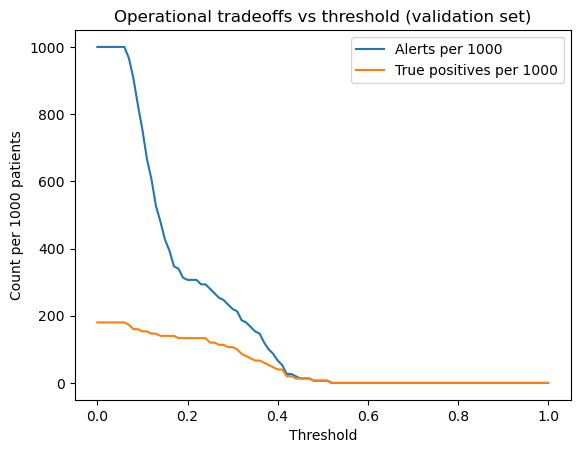

In [11]:
# Get calibrated probabilities
y_score_val = positive_scores(calibrated_clf, X_val)

# Define a grid of thresholds
thresholds = np.linspace(0, 1, 101)
rows = []
for thr in thresholds:
    y_pred = (y_score_val >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    alerts_per_1000 = 1000 * np.mean(y_pred)
    true_pos_per_1000 = 1000 * tp / len(y_val)
    rows.append({
        "threshold": thr,
        "precision": precision,
        "recall": recall,
        "alerts_per_1000": alerts_per_1000,
        "true_pos_per_1000": true_pos_per_1000,
        "FP": fp,
        "FN": fn
    })

df_thr = pd.DataFrame(rows)

# Display a few candidate thresholds for discussion
display(
    df_thr.query("threshold in [0.1, 0.2, 0.3, 0.4, 0.5]")
         .round(3)
         .set_index("threshold")
)

# Plot workload vs threshold
plt.figure()
plt.plot(df_thr["threshold"], df_thr["alerts_per_1000"], label="Alerts per 1000")
plt.plot(df_thr["threshold"], df_thr["true_pos_per_1000"], label="True positives per 1000")
plt.xlabel("Threshold")
plt.ylabel("Count per 1000 patients")
plt.title("Operational tradeoffs vs threshold (validation set)")
plt.legend()
plt.show()

## Choosing an operating threshold

Models produce probabilities, but clinicians are the ones taking decisions, and carring the accountability of their actions.

- Setting a threshold balances in this case, among others, between missed addiction cases and unnecessary undertreatment of pain
- Clear rules make these tradeoffs explicit, explainable, and auditable!

We will run three threshold tuning analyses:
1. **Workload constrained threshold**  
  Capture the most true cases without exceeding a fixed alert capacity for the clinic
2. **Recall floor then maximize precision**  
  Guarantee a minimum case capture for safety, then pick the threshold with the fewest false alarms
3. **Cost based threshold (Bayes rule)**  
  Minimize expected harm using estimated costs for false negatives and false positives

Readouts to watch
- Threshold, precision, recall, alerts per 1000 patients, true positives per 1000, false positives, false negatives
- Connect the chosen rule to clinical policy and resource capacity

### 1. Workload constrained threshold for calibrated_clf on validation

- Alerts budget: maximum alerts per 1000 patients the clinic can review without overloading resources
- Objective: within the alerts budget, choose the threshold that yields the most true positives per 1000 so more patients at real risk are correctly flagged

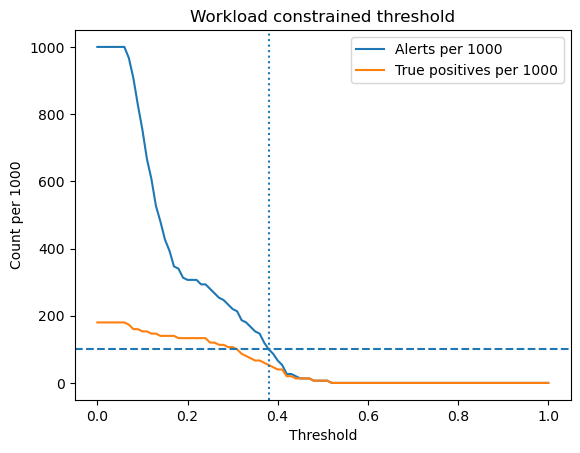

,threshold,precision,recall,TP,FP,TN,FN,alerts_per_1000,true_pos_per_1000
rule,,,,,,,,,
Max TP per 1000 under budget,0.38,0.533,0.296,8.0,7.0,116.0,19.0,100.0,53.333


In [12]:
ALERTS_BUDGET = 100.0  # alerts per 1000 patients

y_score_val = positive_scores(calibrated_clf, X_val)
res = pick_threshold_workload(y_val, y_score_val, alerts_per_1000_max=ALERTS_BUDGET)
tbl = res["table"]

plt.figure()
plt.plot(tbl["threshold"], tbl["alerts_per_1000"], label="Alerts per 1000")
plt.plot(tbl["threshold"], tbl["true_pos_per_1000"], label="True positives per 1000")
plt.axhline(ALERTS_BUDGET, linestyle="--")
plt.axvline(res["threshold"], linestyle=":")
plt.xlabel("Threshold")
plt.ylabel("Count per 1000")
plt.title("Workload constrained threshold")
plt.legend()
plt.show()

summary_df = res["summary"] if isinstance(res["summary"], pd.DataFrame) else pd.DataFrame(res["summary"])
display(summary_df.round(3).set_index("rule"))

,n,positives,min_score,max_score,prevalence,cum_capture,alerts_per_1000,true_pos_per_1000
band,,,,,,,,
1,15,8,0.381,0.520,0.533,0.296,100.0,53.333
2,15,5,0.316,0.378,0.333,0.481,100.0,33.333
3,15,7,0.229,0.316,0.467,0.741,100.0,46.667
4,15,1,0.159,0.221,0.067,0.778,100.0,6.667
5,15,1,0.135,0.156,0.067,0.815,100.0,6.667
6,15,0,0.121,0.134,0.000,0.815,100.0,0.000
7,15,1,0.106,0.120,0.067,0.852,100.0,6.667
8,15,1,0.097,0.105,0.067,0.889,100.0,6.667
9,15,0,0.083,0.093,0.000,0.889,100.0,0.000


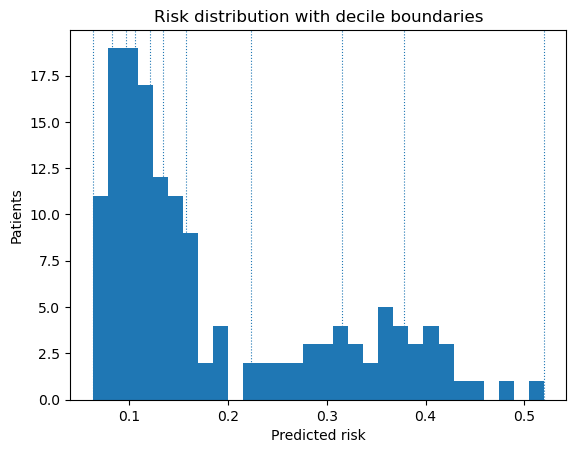

In [13]:
N_BINS = 10  # deciles by default
y_score_val = positive_scores(calibrated_clf, X_val)

# Build bands by quantiles, highest risk = band 1
bands = pd.qcut(y_score_val, q=N_BINS, labels=False, duplicates="drop")
# qcut labels lowest=0..highest=K-1, invert so 1 is highest-risk band
bands = (bands.max() - bands) + 1

df = pd.DataFrame({
    "y_true": y_val.astype(int),
    "score": y_score_val,
    "band": bands.astype(int),
})

summ = (df.groupby("band", as_index=True)
          .agg(n=("y_true","size"),
               positives=("y_true","sum"),
               min_score=("score","min"),
               max_score=("score","max"))
          .sort_index())

summ["prevalence"] = summ["positives"] / summ["n"]
summ["cum_capture"] = summ["positives"].cumsum() / df["y_true"].sum()
summ["alerts_per_1000"] = 1000.0 * summ["n"] / len(df)
summ["true_pos_per_1000"] = 1000.0 * summ["positives"] / len(df)

display(summ.round(3))

# Optional threshold overlay if you already chose one, else set THR=None
THR = None  # e.g., THR = 0.23

# Histogram of risk scores with decile edges
plt.figure()
plt.hist(df["score"], bins=30)
if THR is not None:
    plt.axvline(THR, linestyle="--")
# draw decile boundaries
edges = np.quantile(df["score"], np.linspace(0,1,N_BINS+1))
for x in edges:
    plt.axvline(x, linestyle=":", linewidth=0.8)
plt.xlabel("Predicted risk")
plt.ylabel("Patients")
plt.title("Risk distribution with decile boundaries")
plt.show()


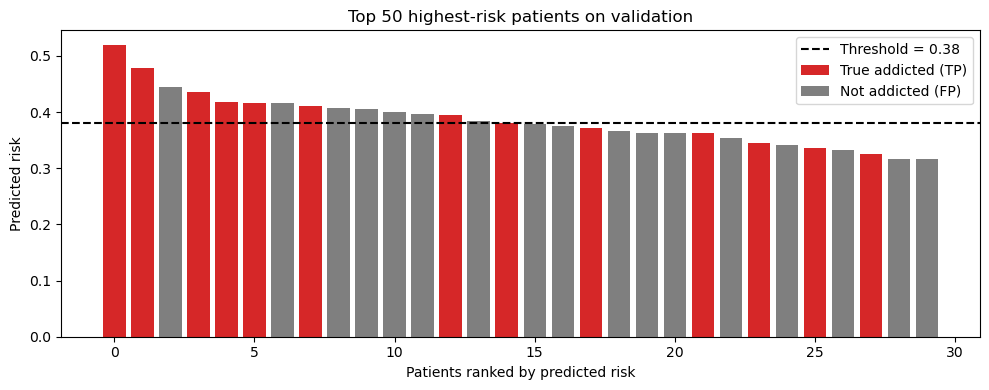

In [14]:
THR = res["threshold"] # <- use the threshold from the previous step
y_score_val = positive_scores(calibrated_clf, X_val)
ids = np.arange(len(y_val))

# Sort patients by predicted risk
order = np.argsort(-y_score_val)
top_idx = order[:30]   # top 30 for visualization
top_scores = y_score_val[top_idx]
top_true = np.asarray(y_val)[top_idx].astype(int)

# Split indices for TP vs FP
tp_idx = np.where(top_true == 1)[0]
fp_idx = np.where(top_true == 0)[0]

plt.figure(figsize=(10, 4))
plt.bar(tp_idx, top_scores[tp_idx], color="tab:red", label="True addicted (TP)")
plt.bar(fp_idx, top_scores[fp_idx], color="tab:gray", label="Not addicted (FP)")
plt.axhline(THR, linestyle="--", color="black", label=f"Threshold = {THR:.2f}")

plt.xlabel("Patients ranked by predicted risk")
plt.ylabel("Predicted risk")
plt.title("Top 50 highest-risk patients on validation")
plt.legend()
plt.tight_layout()
plt.show()

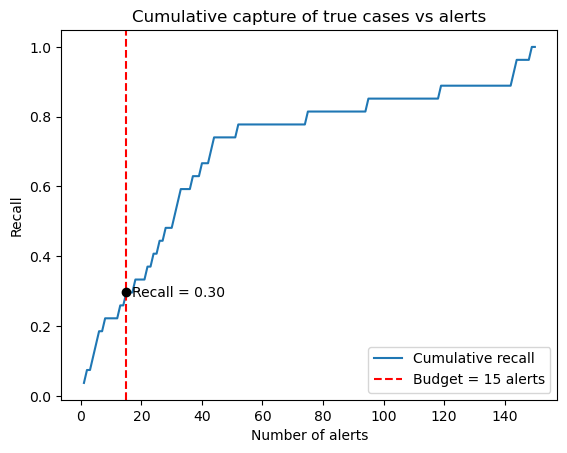

In [15]:
y_score_val = positive_scores(calibrated_clf, X_val)
order = np.argsort(-y_score_val)
y_sorted = np.asarray(y_val)[order].astype(int)

# Cumulative recall
cum_tp = np.cumsum(y_sorted)
total_pos = cum_tp[-1] if cum_tp.size else 0
alerts = np.arange(1, len(y_sorted) + 1)
recall_curve = cum_tp / total_pos if total_pos > 0 else np.zeros_like(cum_tp)

# Budget for alerts
n_budget = int(np.ceil(ALERTS_BUDGET * len(y_val) / 1000.0))

# Recall at budget
recall_at_budget = recall_curve[n_budget - 1] if n_budget > 0 and n_budget <= len(y_val) else 0.0

# Plot
plt.figure()
plt.plot(alerts, recall_curve, label="Cumulative recall")
plt.axvline(n_budget, linestyle="--", color="red", label=f"Budget = {n_budget} alerts")

# Annotate recall at budget
plt.scatter(n_budget, recall_at_budget, color="black", zorder=5)
plt.text(n_budget + 2, recall_at_budget, f"Recall = {recall_at_budget:.2f}", va="center")

plt.xlabel("Number of alerts")
plt.ylabel("Recall")
plt.title("Cumulative capture of true cases vs alerts")
plt.legend()
plt.show()

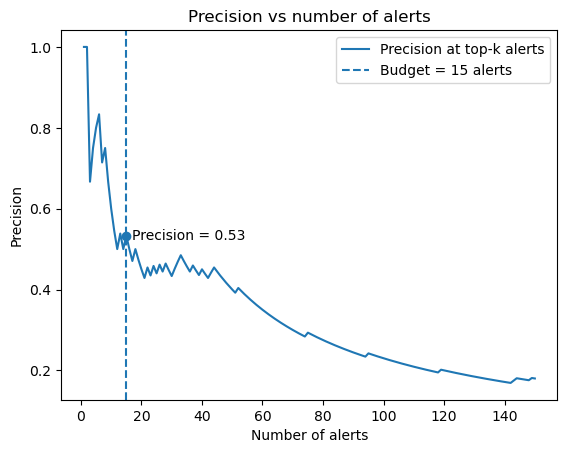

In [16]:
# Cumulative precision at top-k alerts
alerts = np.arange(1, len(y_sorted) + 1)
cum_tp = np.cumsum(y_sorted)
precision_curve = cum_tp / alerts

# Alerts budget scaled to validation size
prec_at_budget = precision_curve[n_budget - 1] if 0 < n_budget <= len(y_sorted) else 0.0

# Plot
plt.figure()
plt.plot(alerts, precision_curve, label="Precision at top-k alerts")
plt.axvline(n_budget, linestyle="--", label=f"Budget = {n_budget} alerts")
plt.scatter(n_budget, prec_at_budget, zorder=5)
plt.text(n_budget + max(2, len(y_sorted)//100), prec_at_budget, f"Precision = {prec_at_budget:.2f}", va="center")

plt.xlabel("Number of alerts")
plt.ylabel("Precision")
plt.title("Precision vs number of alerts")
plt.legend()
plt.show()


### 2. Recall floor then maximize precision for calibrated_clf on validation

- Recall floor: minimum acceptable recall set by safety policy to limit missed addiction cases
- Precision objective: among thresholds meeting the recall floor, pick the one with highest precision to reduce unnecessary undertreatment and clinician workload

Deciding which recall floor to sue:
1. The chosen floor is a value judgment balancing patient safety vs resource burden
2. In medicine, it's often the case that missing a true case (false negative) is often much worse than raising extra alarms (false positives)
3. A recall floor enforces a safety guarantee: the model must capture at least e.g. 60% of patients who will become addicted

Among thresholds that satisfy recall ≥ 0.6, you then pick the one with the best precision, to minimize unnecessary undertreatment and workload

,precision,recall,TP,FP,TN,FN,alerts_per_1000,true_pos_per_1000
threshold,,,,,,,,
0.28,0.459,0.63,17,20,103,10,246.667,113.333


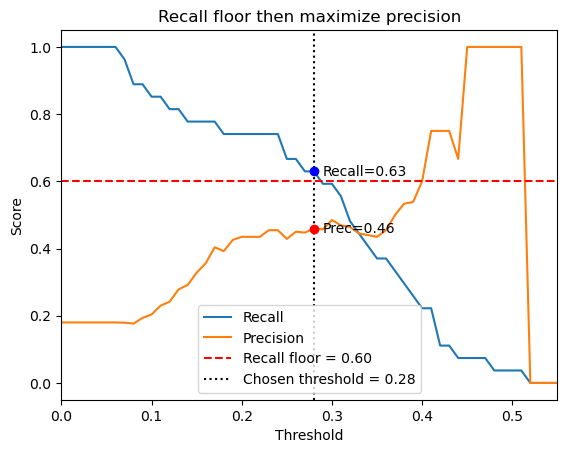

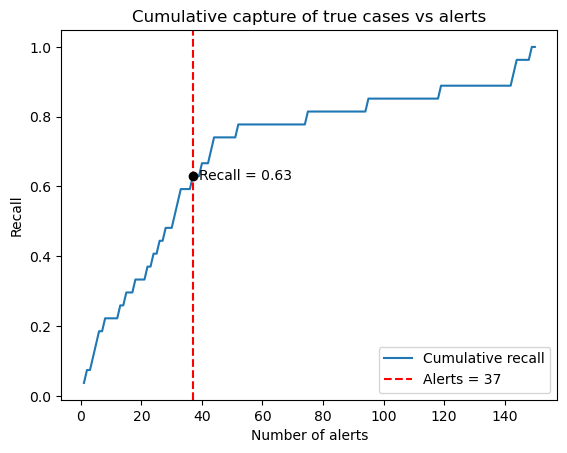

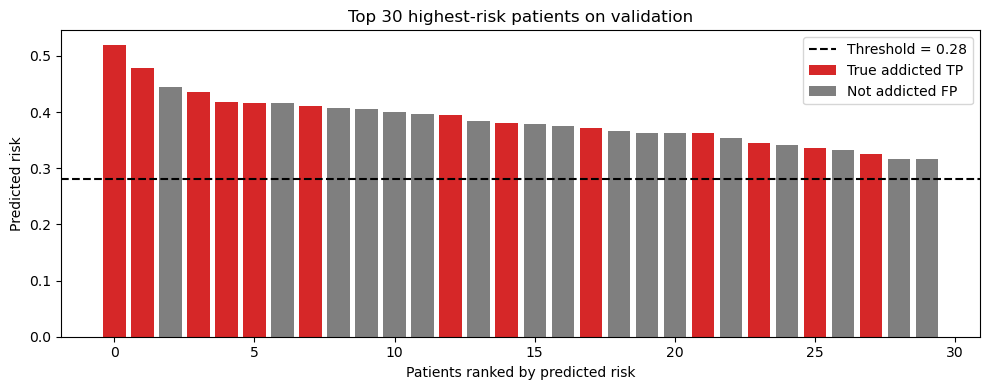

In [16]:
# Step 1: choose threshold by recall floor
RECALL_FLOOR = 0.60 # <- judgment call
y_score_val = positive_scores(calibrated_clf, X_val)
res = pick_threshold_recall_floor(y_val, y_score_val, recall_floor=RECALL_FLOOR)
THR = float(res["threshold"])

# Step 2: numeric summary at the chosen threshold
summary_df = summary_at_threshold(y_val, y_score_val, THR)
display(summary_df.round(3).set_index("threshold"))

# Step 3: precision and recall vs threshold with annotations
plot_recall_floor_curves(y_val, y_score_val, recall_floor=RECALL_FLOOR, chosen_threshold=THR)

# Step 4: cumulative recall vs alerts with vertical line at alerts implied by THR
plot_cumulative_recall_at_threshold(y_val, y_score_val, chosen_threshold=THR)

# Step 5: patient-level prioritization view at THR
plot_topk_at_threshold(y_val, y_score_val, chosen_threshold=THR, top_k=30)

### 3. Cost based threshold for calibrated_clf on validation

- C_FN missed addiction case: downstream care for opioid use disorder, overdose treatment, long-term morbidity, lost productivity, family and social harms, quality adjusted life year loss

- C_FP undertreated pain when the patient would not have become addicted: pain-related disutility, extra visits, alternative therapies, short term function loss, patient dissatisfaction

In [ ]:
# Set domain costs
C_FN = 100.0  # missed addiction case
C_FP = 10.0   # undertreated pain

y_score_val = positive_scores(calibrated_clf, X_val)

res = pick_threshold_cost(y_val, y_score_val, C_FP=C_FP, C_FN=C_FN)
tbl = res["table"].copy()
tbl["expected_cost"] = C_FP * tbl["FP"] + C_FN * tbl["FN"]

# Plot expected cost vs threshold with the two candidate thresholds
plt.figure()
plt.plot(tbl["threshold"], tbl["expected_cost"])
plt.xlabel("Threshold")
plt.ylabel("Expected cost")
plt.title("Cost based threshold selection")
t_formula = res["threshold_formula"]
t_emp = res["threshold_empirical"]
plt.axvline(t_formula, linestyle="--")
plt.axvline(t_emp, linestyle=":")
plt.show()

# Compact comparison table
summary_df = res["summary"] if isinstance(res["summary"], pd.DataFrame) else pd.DataFrame(res["summary"])
display(summary_df.round(3).set_index("rule"))

In [ ]:
# 6. Curves

_ = RocCurveDisplay.from_predictions(y_test, proba_test)
plt.title("ROC curve")
plt.show()

_ = PrecisionRecallDisplay.from_predictions(y_test, proba_test)
plt.title("Precision recall curve")
plt.show()

In [ ]:
# 7. Quick programmatic fairness check by Low_inc

sf = X_test["Low_inc"]
mf = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "selection_rate": selection_rate,
        "tpr": true_positive_rate,
        "fpr": false_positive_rate
    },
    y_true=y_test,
    y_pred=pred_test,
    sensitive_features=sf
)
mf.by_group

In [ ]:
# 8. Responsible AI insights

# Mark binary flags as categorical so the RAI dashboard can include data balance measures
categorical_features = cat_like_binary_cols.copy()

# RAIInsights expects training and test data with target included
train_with_target = X_train.copy()
train_with_target[target_col] = y_train

test_with_target = X_test.copy()
test_with_target[target_col] = y_test

rai_insights = RAIInsights(
    model=clf,
    train=train_with_target,
    test=test_with_target,
    target_column=target_col,
    task_type="classification",
    categorical_features=categorical_features
)

# Add components
rai_insights.explainer.add()
rai_insights.error_analysis.add()

# Fairness assessment focused on Low_inc
try:
    rai_insights.fairness.add(sensitive_features=["Low_inc"])
except Exception as e:
    print("Fairness add warning:", e)

# Optional components that may require extra dependencies
try:
    # Counterfactuals use DiCE under the hood
    rai_insights.counterfactual.add(total_CFs=50, desired_class="opposite")
except Exception as e:
    print("Counterfactuals not added:", e)

try:
    # Causal analysis over a subset of features
    treatment_features = ["rx_ds"]
    heterogeneity_features = ["Surgery"]
    rai_insights.causal.add(treatment_features=treatment_features,
                            heterogeneity_features=heterogeneity_features)
except Exception as e:
    print("Causal analysis not added:", e)

rai_insights.compute()
print("RAI insights computed")

In [ ]:
# 9. Launch Responsible AI dashboard

# The feature_flights argument can enable the data balance experience when categorical_features are present
ResponsibleAIDashboard(rai_insights, feature_flights="dataBalanceExperience")

In [ ]:
# 10. Save model and splits for reuse

import joblib
import json

out_dir = Path("./artifacts")
out_dir.mkdir(exist_ok=True, parents=True)

joblib.dump(clf, out_dir / "od_lr_pipeline.joblib")

meta = {
    "created": datetime.utcnow().isoformat() + "Z",
    "n_train": int(X_train.shape[0]),
    "n_test": int(X_test.shape[0]),
    "features": list(X.columns),
    "categorical_features": categorical_features,
    "target": target_col,
    "metrics": metrics
}
with open(out_dir / "run_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved:", list(out_dir.iterdir()))

# References

